In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
from collections import Counter
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import balanced_accuracy_score, roc_curve, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from xgboost import plot_tree

from imblearn.combine import SMOTEENN


import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the cleaned dataset
data = pd.read_csv('Processed_Telecom_Churn.csv')

# Display the first few rows to inspect the data
data.head()

,telecom_partner,gender,age,state,city,num_dependents,estimated_salary,calls_made,sms_sent,data_used,churn,tenure_days
0,2,0,25,10,4,4,124962,44.0,45.0,4987.0,0,1879
1,2,0,55,16,5,2,130556,62.0,39.0,5973.0,0,1879
2,3,0,57,1,2,0,148828,49.0,24.0,193.0,1,1879
3,1,1,46,22,4,1,38722,80.0,25.0,9377.0,1,1879
4,1,0,26,24,2,2,55098,78.0,15.0,1393.0,0,1879


In [3]:
X = data.drop(columns=['churn'])
y = data['churn']
X.head()

,telecom_partner,gender,age,state,city,num_dependents,estimated_salary,calls_made,sms_sent,data_used,tenure_days
0,2,0,25,10,4,4,124962,44.0,45.0,4987.0,1879
1,2,0,55,16,5,2,130556,62.0,39.0,5973.0,1879
2,3,0,57,1,2,0,148828,49.0,24.0,193.0,1879
3,1,1,46,22,4,1,38722,80.0,25.0,9377.0,1879
4,1,0,26,24,2,2,55098,78.0,15.0,1393.0,1879


In [4]:
from sklearn.feature_selection import mutual_info_classif
# Calculate MI Scores
mi_scores = mutual_info_classif(X, y, random_state=42)

# Create DataFrame for MI Scores
mi_data = pd.DataFrame({'Feature': X.columns, 'MI Score': mi_scores})
mi_data.sort_values(by='MI Score', ascending=False, inplace=True)

# Display feature importance
print("Mutual Information Scores:")
print(mi_data)

Mutual Information Scores:
             Feature  MI Score
1             gender  0.032114
0    telecom_partner  0.009579
5     num_dependents  0.008994
4               city  0.006437
3              state  0.001115
8           sms_sent  0.000913
7         calls_made  0.000794
2                age  0.000407
10       tenure_days  0.000264
9          data_used  0.000011
6   estimated_salary  0.000000


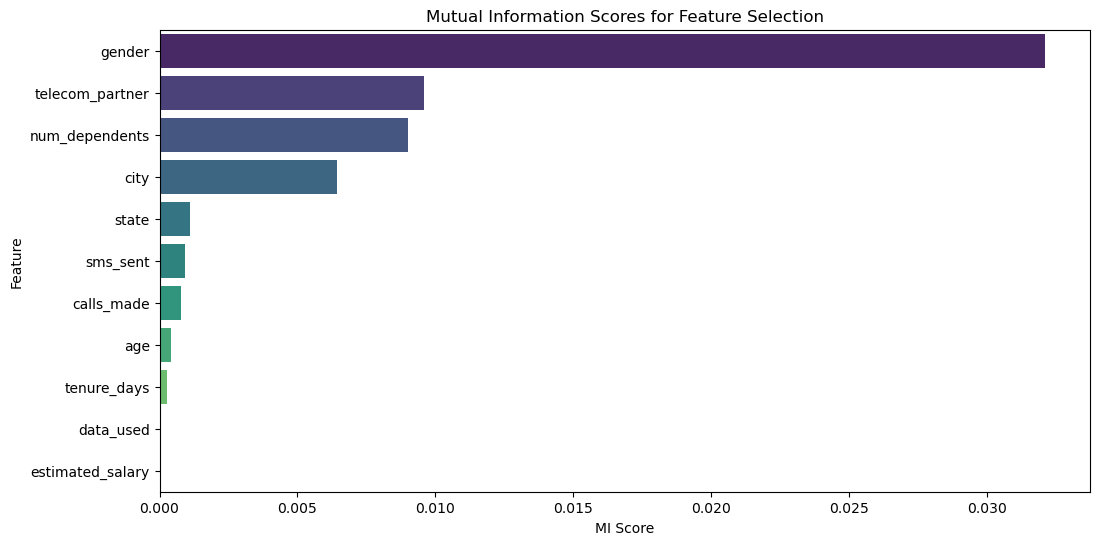

In [5]:
# Visualize MI Scores
plt.figure(figsize=(12, 6))
sns.barplot(x='MI Score', y='Feature', data=mi_data, palette='viridis')
plt.title('Mutual Information Scores for Feature Selection')
plt.show()

In [6]:
# Select Features with MI Score > 0
selected_features = mi_data[mi_data['MI Score'] > 0]['Feature'].tolist()
X = X[selected_features]

print("Selected Features:", selected_features)

Selected Features: ['gender', 'telecom_partner', 'num_dependents', 'city', 'state', 'sms_sent', 'calls_made', 'age', 'tenure_days', 'data_used']


In [7]:
# Class Distribution Before SMOTEENN
print("Class distribution before SMOTEENN:", Counter(y))

# Apply SMOTEENN
smoteenn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smoteenn.fit_resample(X, y)

# Class Distribution After SMOTEENN
print("Class distribution after SMOTEENN:", Counter(y_train_resampled))

Class distribution before SMOTEENN: Counter({0: 194726, 1: 48827})
Class distribution after SMOTEENN: Counter({1: 157179, 0: 77662})


In [8]:
# Perform stratified train-test split to maintain the class distribution
X_train, X_test, y_train, y_test = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=42, stratify=y_train_resampled)

In [9]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (187872, 10)
X_test shape: (46969, 10)


In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
#List to store models
models = []

In [12]:
# Function to print the evaluation metrics
def eval_metrics(model, X_test, y_test):
    y_pred_model = model.predict(X_test)       
    y_probabilities = model.predict_proba(X_test)[:, 1]
    
    print('Precision: ', precision_score(y_test, y_pred_model))
    print('Recall: ', recall_score(y_test, y_pred_model))
    print('F1 Score: ', f1_score(y_test, y_pred_model))
    print('ROC AUC Score: ', roc_auc_score(y_test, y_probabilities))
   
    plt.figure(figsize=(12,6))
   
    
    
    # Confusion matrix
    plt.subplot(121)
    conf_mat = confusion_matrix(y_test, y_pred_model)
    sns.heatmap(conf_mat, fmt="d", annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')

    # ROC AUC Score
    model_roc_auc = roc_auc_score(y_test, y_probabilities) 
    fpr, tpr, thresholds = roc_curve(y_test, y_probabilities)
    
    plt.subplot(122)
    plt.plot(fpr, tpr, color='darkorange', lw=1, label="AUC : %.3f" % model_roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    
    plt.show()
    
   

Precision:  0.7000720115218435
Recall:  0.9277579844763965
F1 Score:  0.797991682171391
ROC AUC Score:  0.658455969278989


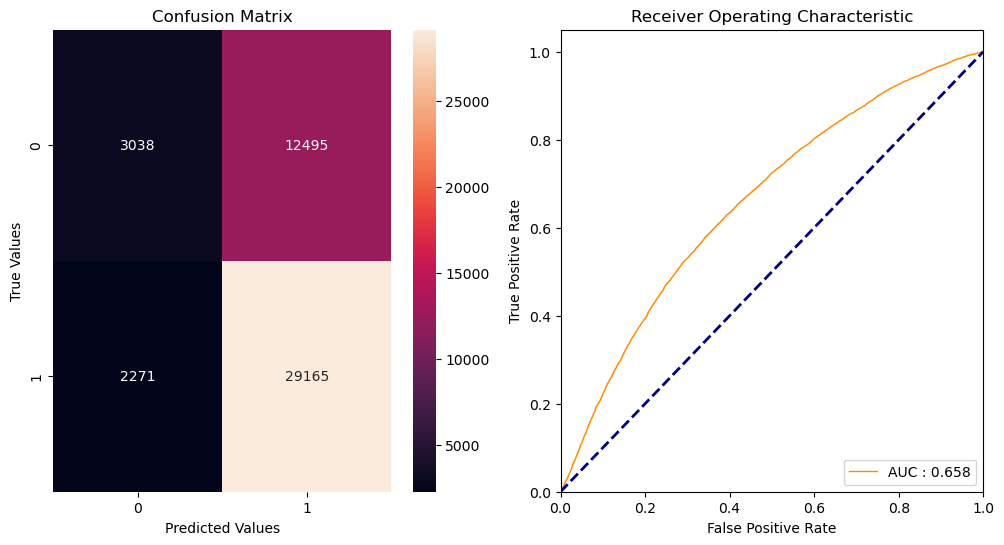

In [13]:
# Initialize and fit different models
# 1. Logistic Regression
churn_lr = LogisticRegression(random_state=42, max_iter=1000)
churn_lr.fit(X_train, y_train)
models.append(churn_lr)
eval_metrics(churn_lr, X_test, y_test)

Precision:  0.8165468754904115
Recall:  0.8275862068965517
F1 Score:  0.8220294800701455
ROC AUC Score:  0.7256452891174962


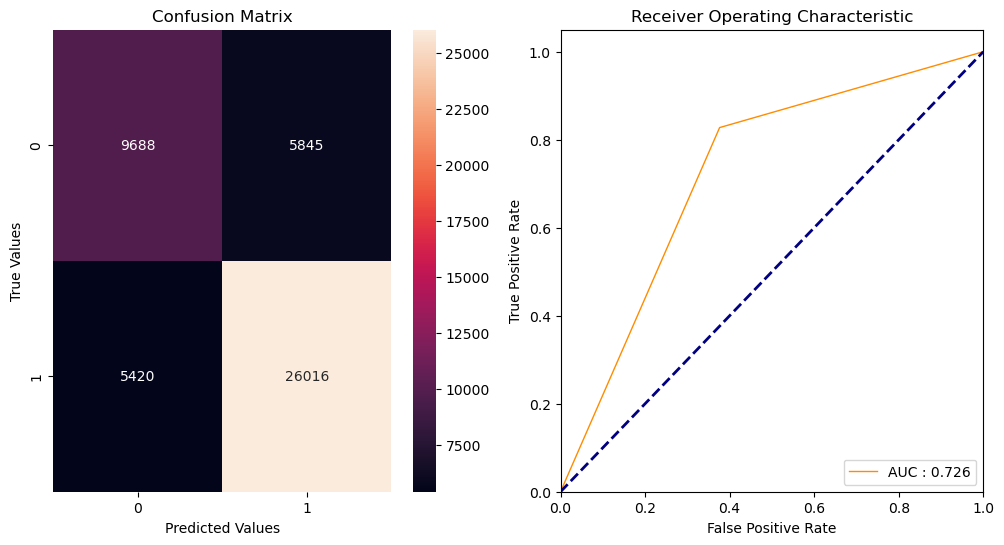

In [14]:
# 2. DecisionTreeClassifier
churn_DT = DecisionTreeClassifier(random_state=42)
churn_DT.fit(X_train, y_train)
models.append(churn_DT)
eval_metrics(churn_DT, X_test, y_test)

Precision:  0.725288439497746
Recall:  0.9058722483776562
F1 Score:  0.8055842374008119
ROC AUC Score:  0.7232841711787783


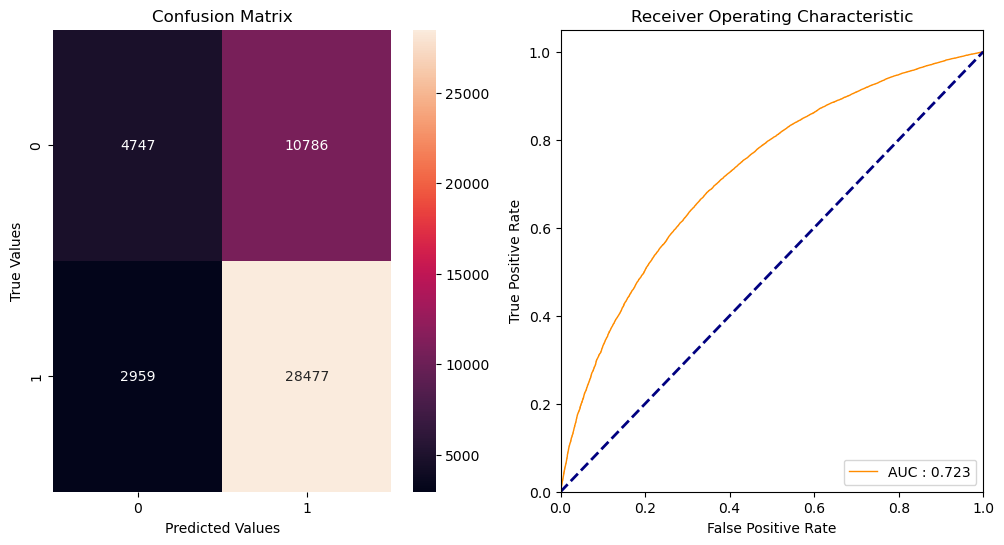

In [15]:
# 3. Gaussian Naive Bayes
churn_GNB = GaussianNB()
churn_GNB.fit(X_train, y_train)
models.append(churn_GNB)
eval_metrics(churn_GNB, X_test, y_test)

Precision:  0.7977133312213807
Recall:  0.8811235526148365
F1 Score:  0.8373463927810276
ROC AUC Score:  0.8405855535133583


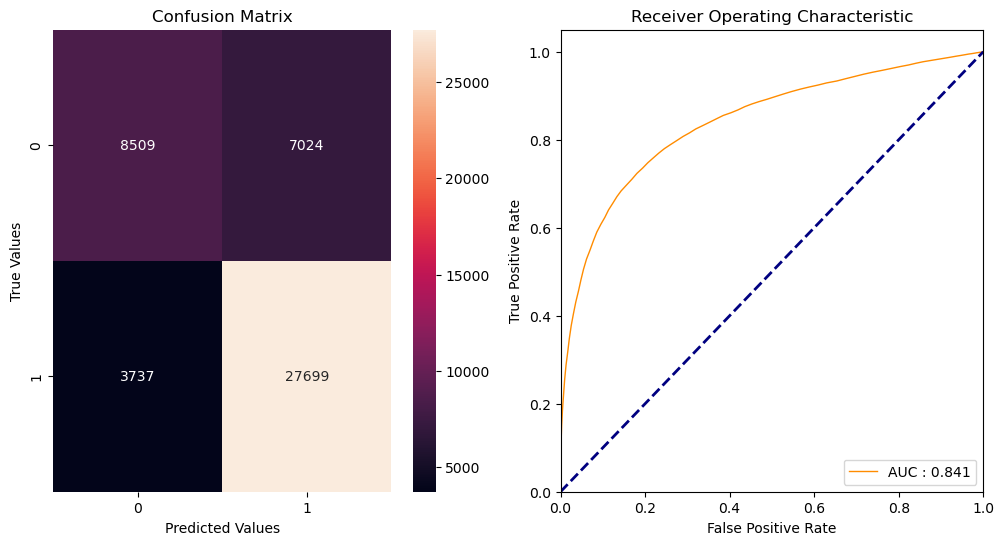

In [16]:
# 4. Random Forest
churn_rf = RandomForestClassifier(random_state=42, n_jobs=-1)
churn_rf.fit(X_train, y_train)
models.append(churn_rf)
eval_metrics(churn_rf, X_test, y_test)

Precision:  0.7521186440677966
Recall:  0.9034228273317216
F1 Score:  0.8208566969188971
ROC AUC Score:  0.7987952417441222


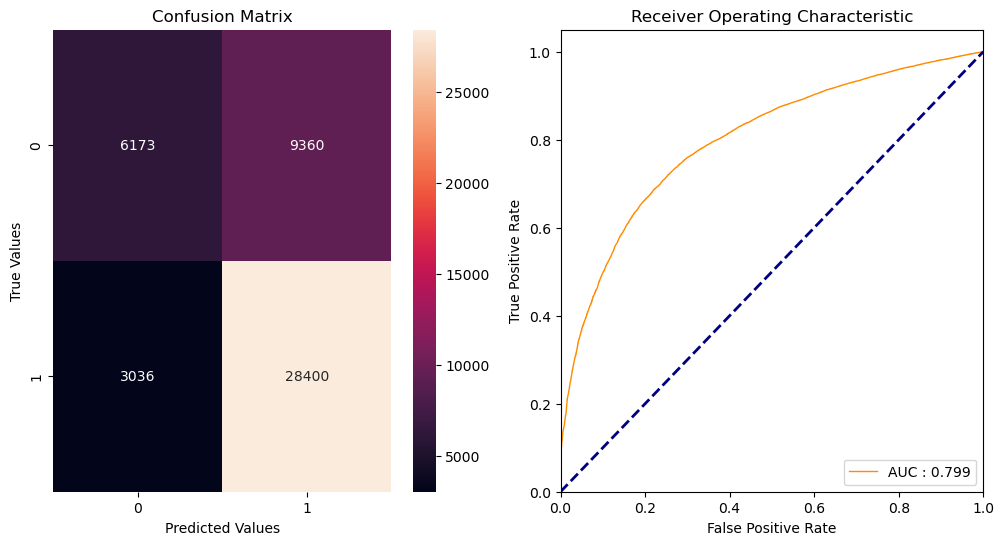

In [17]:
# 5. Gradient Boosting
churn_gb = GradientBoostingClassifier(random_state=42)
churn_gb.fit(X_train, y_train)
models.append(churn_gb)
eval_metrics(churn_gb, X_test, y_test)

Precision:  0.8509848608171903
Recall:  0.831467107774526
F1 Score:  0.8411127737284999
ROC AUC Score:  0.876965807016797


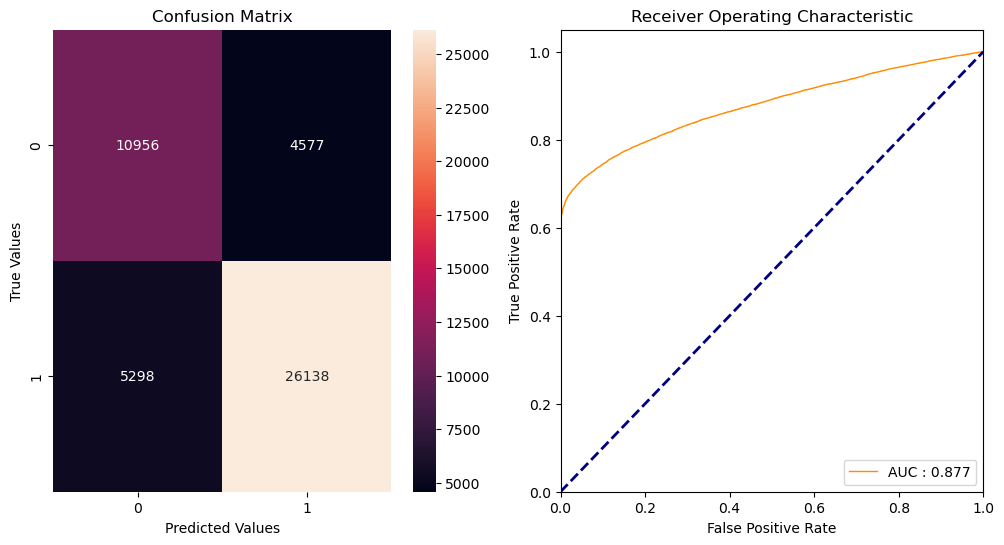

In [18]:
#6. XGBoost
churn_xgb = xgb.XGBClassifier(objective='binary:logistic', seed=42, n_jobs=-1)
churn_xgb.fit(X_train, y_train)
models.append(churn_xgb)
eval_metrics(churn_xgb, X_test, y_test)

In [19]:
from sklearn.model_selection import StratifiedKFold
# Model Comparison using K-Fold Cross Validation
result_col = ["Algorithm", "AUC Mean", "Bal Acc Mean", "Recall", "F1"]
model_results = pd.DataFrame(columns=result_col)

i = 0
for model in models:
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    cv_acc_results = cross_val_score(model, X_train, y_train,
                                     cv=skf, scoring="balanced_accuracy", n_jobs=-1)
    cv_auc_results = cross_val_score(model, X_train, y_train,
                                     cv=skf, scoring="roc_auc", n_jobs=-1)
    cv_recall_results = cross_val_score(model, X_train, y_train,
                                        cv=skf, scoring="recall", n_jobs=-1)
    cv_f1_results = cross_val_score(model, X_train, y_train,
                                        cv=skf, scoring="f1", n_jobs=-1)
   

    model_results.loc[i] = [model.__class__.__name__,
                                    round(cv_auc_results.mean() * 100, 2),
                                    round(cv_acc_results.mean() * 100, 2),
                                    round(cv_recall_results.mean() * 100, 2),
                                    round(cv_f1_results.mean() * 100, 2)
                                    
                           ]
    i += 1

model_results = model_results.sort_values(by=['AUC Mean'], ascending=False)
print(model_results)

                    Algorithm  AUC Mean  Bal Acc Mean  Recall     F1
5               XGBClassifier     87.61         76.22   83.52  83.99
3      RandomForestClassifier     82.30         70.06   87.23  82.88
4  GradientBoostingClassifier     80.07         65.58   90.49  82.34
2                  GaussianNB     72.71         61.07   90.82  80.82
1      DecisionTreeClassifier     71.03         71.03   81.84  81.23
0          LogisticRegression     66.28         56.34   92.79  79.86


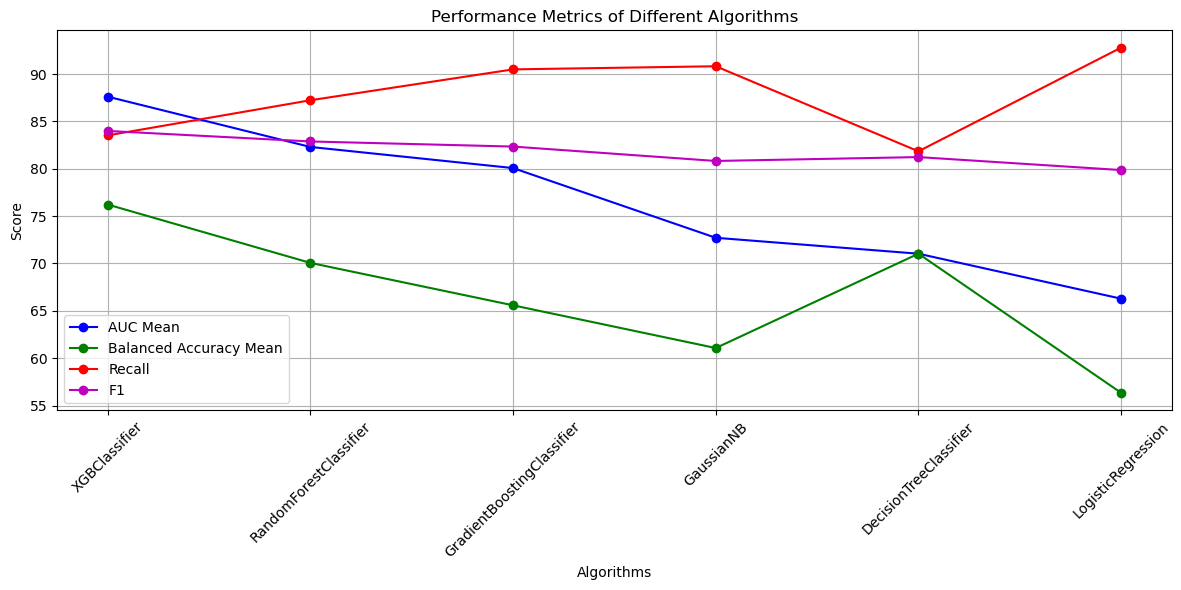

In [20]:
# Sort results by AUC score
model_results = model_results.sort_values(by=['AUC Mean'], ascending=False)

# Plot model performance
plt.figure(figsize=(12, 6))
plt.plot(model_results['Algorithm'], model_results['AUC Mean'], marker='o', label='AUC Mean', color='b')
plt.plot(model_results['Algorithm'], model_results['Bal Acc Mean'], marker='o', label='Balanced Accuracy Mean', color='g')
plt.plot(model_results['Algorithm'], model_results['Recall'], marker='o', label='Recall', color='r')
plt.plot(model_results['Algorithm'], model_results['F1'], marker='o', label='F1', color='m')


plt.xticks(rotation=45)
plt.xlabel('Algorithms')
plt.ylabel('Score')
plt.title('Performance Metrics of Different Algorithms')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define hyperparameter search space
rf_params_dist = {
    'n_estimators': [100, 200, 300],  
    'max_depth': [10, 20, 30, None],  
    'max_features': ['sqrt', 'log2', None], 
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf' : [1, 2, 4],
    'class_weight': ['balanced'],  
    'ccp_alpha': [0.0, 0.01, 0.1]
}

# Initialize base model
churn_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Perform Randomized Search with Cross-Validation
rf_random = RandomizedSearchCV(
    churn_rf, 
    rf_params_dist, 
    scoring='roc_auc', 
    cv=skf, 
    n_iter=10,  # Randomly search 10 combinations
    verbose=2,  
    n_jobs=-1,
    random_state=42
)

# Fit RandomizedSearchCV
rf_random.fit(X_train, y_train)

# Get best parameters
best_params = rf_random.best_params_
print("Best Parameters for RF:", best_params)
print("Best Score for RF:", rf_random.best_score_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters for RF: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None, 'class_weight': 'balanced', 'ccp_alpha': 0.0}
Best Score for RF: 0.8197564923337567


In [22]:
# Train the optimized model
churn_rf_optimal = RandomForestClassifier(
                                           n_estimators=best_params['n_estimators'],
                                           max_depth=best_params['max_depth'],
                                           max_features=best_params['max_features'],
                                           min_samples_split=best_params['min_samples_split'],
                                           min_samples_leaf=best_params['min_samples_leaf'],
                                           class_weight=best_params['class_weight'],
                                           ccp_alpha=best_params['ccp_alpha'],
                                           random_state=42,
                                           n_jobs=-1
                                          )

# Fit the model on training data
churn_rf_optimal.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_features='log2',
                       min_samples_leaf=2, n_estimators=200, n_jobs=-1,
                       random_state=42)

Random Forest Model Evaluation:
Precision:  0.8091249065071054
Recall:  0.8603193790558595
F1 Score:  0.8339371887574968
ROC AUC Score:  0.834180733650509


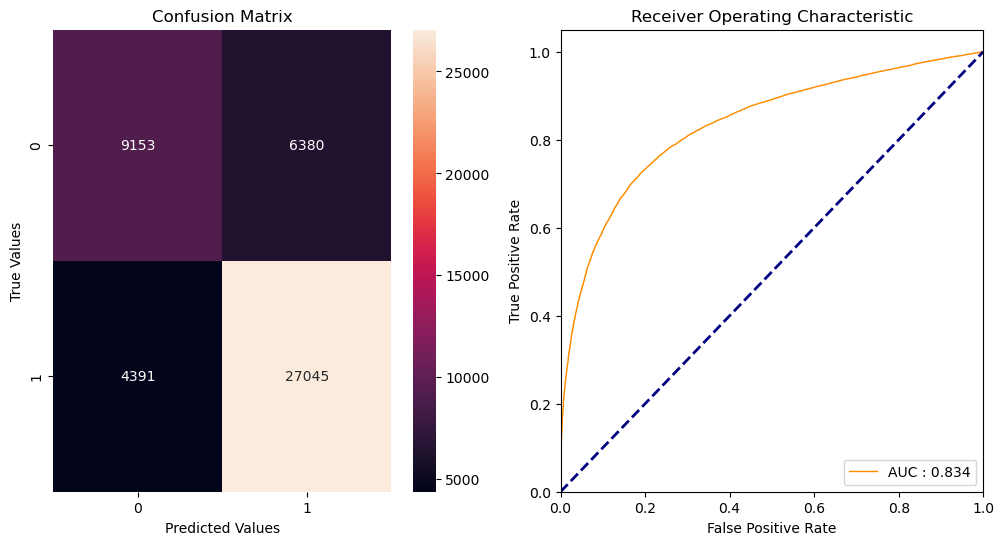

In [23]:
# Evaluate performance
print("Random Forest Model Evaluation:")
eval_metrics(churn_rf_optimal, X_test, y_test)

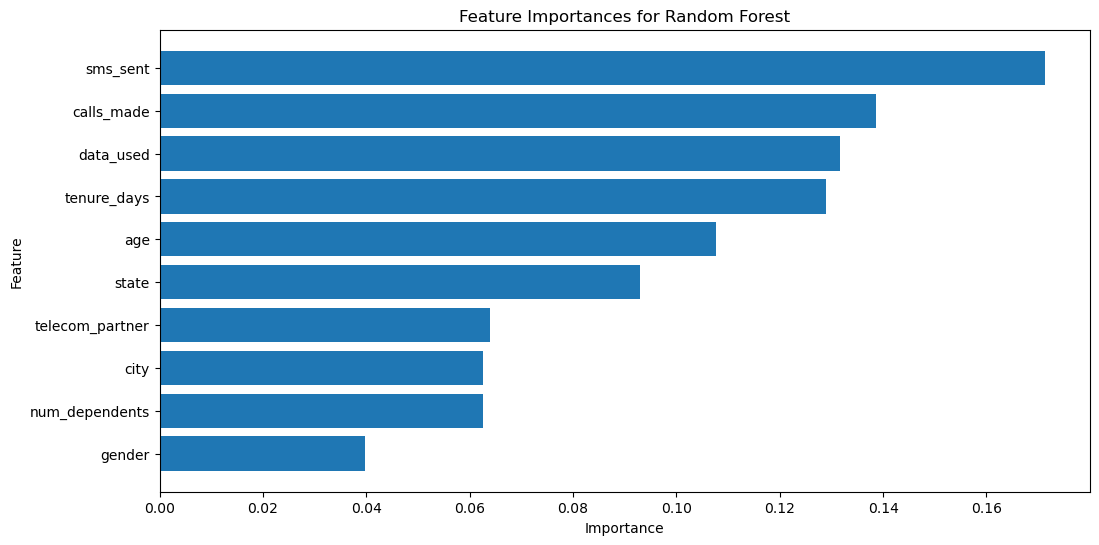

In [24]:
# Feature importance visualization for Random Forest
importances = churn_rf_optimal.feature_importances_
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=True)

plt.figure(figsize=(12, 6))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for Random Forest')
plt.show()

In [31]:
# Define hyperparameter search space

xgb_params_dist = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2], 
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.3], 
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 5, 10],  
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'scale_pos_weight': [0.5, 1, 1.5, 2, 5]
}

# Initialize base model
churn_xgb = xgb.XGBClassifier(objective='binary:logistic', seed=42, n_jobs=-1)


# Perform Randomized Search
xgb_random = RandomizedSearchCV(
    churn_xgb,
    xgb_params_dist,
    scoring='roc_auc',
    cv=skf,
    n_iter=10,  # Randomly search 10 combinations
    verbose=2,
    n_jobs=-1
)

# Fit RandomizedSearchCV
xgb_random.fit(X_train, y_train)

# Get best parameters
best_params = xgb_random.best_params_
print("Best Parameters for XGBoost:", best_params)
print("Best Score for XGBoost:", xgb_random.best_score_)




Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters for XGBoost: {'subsample': 1.0, 'scale_pos_weight': 1.5, 'reg_lambda': 5, 'reg_alpha': 0.1, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.6}
Best Score for XGBoost: 0.8908990308159138


In [32]:
# Train the optimized model
churn_xgb_optimal = xgb.XGBClassifier(objective='binary:logistic',
                                  n_estimators=best_params['n_estimators'],
                                  learning_rate=best_params['learning_rate'],
                                  max_depth=best_params['max_depth'],
                                  min_child_weight=best_params['min_child_weight'],
                                  gamma=best_params['gamma'],
                                  reg_alpha=best_params['reg_alpha'],
                                  reg_lambda=best_params['reg_lambda'],
                                  subsample=best_params['subsample'],
                                  colsample_bytree=best_params['colsample_bytree'],
                                  scale_pos_weight=best_params['scale_pos_weight'],
                                  seed=42,
                                  n_jobs=-1,
                                  eval_metric="aucpr",
                                  early_stopping_rounds=10,
                                 )

# Fit the model on training data
churn_xgb_optimal.fit(X_train, y_train,
                     eval_set=[(X_test, y_test)],
                     verbose=True
                     )

[0]	validation_0-aucpr:0.78987
[1]	validation_0-aucpr:0.81001
[2]	validation_0-aucpr:0.86111
[3]	validation_0-aucpr:0.86554
[4]	validation_0-aucpr:0.86543
[5]	validation_0-aucpr:0.86823
[6]	validation_0-aucpr:0.86790
[7]	validation_0-aucpr:0.87192
[8]	validation_0-aucpr:0.87205
[9]	validation_0-aucpr:0.87986
[10]	validation_0-aucpr:0.88450
[11]	validation_0-aucpr:0.88567
[12]	validation_0-aucpr:0.88670
[13]	validation_0-aucpr:0.89095
[14]	validation_0-aucpr:0.89459
[15]	validation_0-aucpr:0.89828
[16]	validation_0-aucpr:0.89776
[17]	validation_0-aucpr:0.89785
[18]	validation_0-aucpr:0.90361
[19]	validation_0-aucpr:0.90328
[20]	validation_0-aucpr:0.90756
[21]	validation_0-aucpr:0.90802
[22]	validation_0-aucpr:0.90957
[23]	validation_0-aucpr:0.91137
[24]	validation_0-aucpr:0.91378
[25]	validation_0-aucpr:0.91418
[26]	validation_0-aucpr:0.91442
[27]	validation_0-aucpr:0.91446
[28]	validation_0-aucpr:0.91533
[29]	validation_0-aucpr:0.91544
[30]	validation_0-aucpr:0.91806
[31]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

XGBoost Model Evaluation:
Precision:  0.8183355585224744
Recall:  0.8774017050515333
F1 Score:  0.8468399318401619
ROC AUC Score:  0.8915837302563259


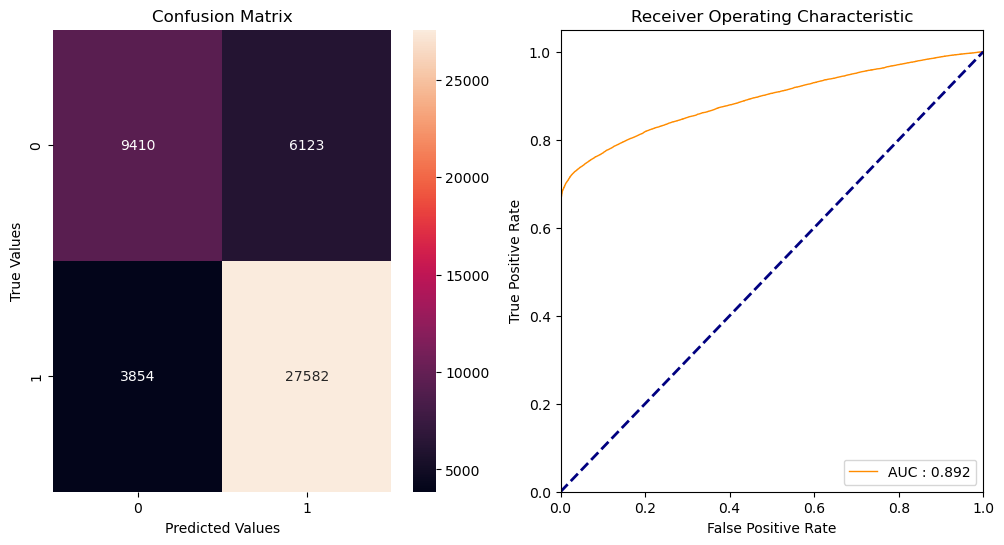

In [33]:
# Evaluate performance
print("XGBoost Model Evaluation:")
eval_metrics(churn_xgb_optimal, X_test, y_test)

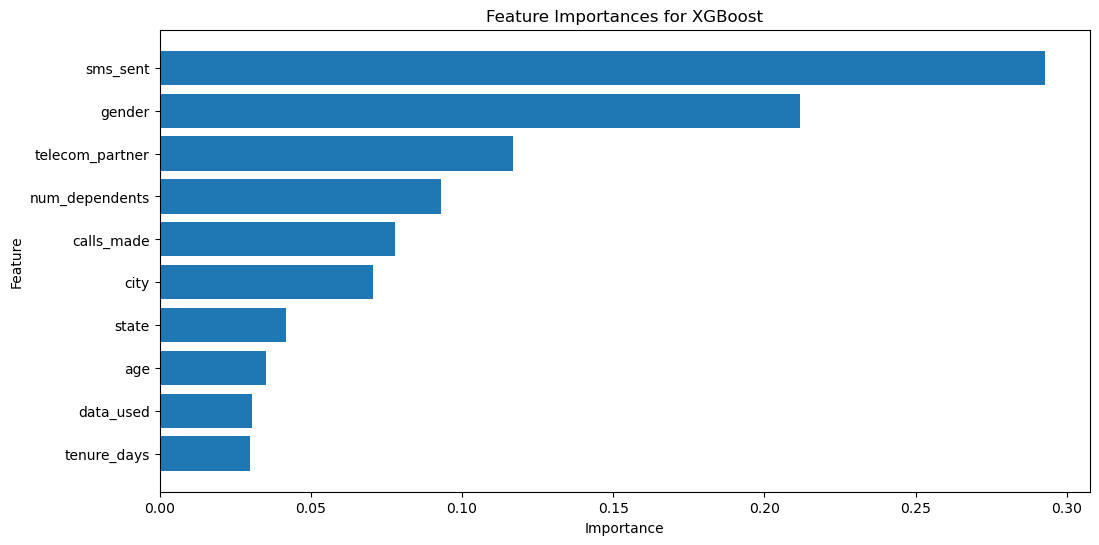

In [34]:
# Feature importance visualization for XGBoost
importances = churn_xgb_optimal.feature_importances_
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=True)

plt.figure(figsize=(12, 6))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for XGBoost')
plt.show()

In [35]:
import pickle

# Save the final XGBoost model to disk
pickle.dump(churn_xgb_optimal, open('churn_xgb_optimal.pkl', 'wb'))

In [40]:
# Save the final XGBoost model to disk
pickle.dump(churn_rf_optimal, open('churn_rf_optimal.pkl', 'wb'))